# Section 1: Data Exploration

### ~ import relevant libraries ~

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pydicom

from os import listdir
import os

from skimage.transform import resize
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split, StratifiedKFold

from keras.applications import ResNet50, VGG16
from keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from keras.applications.vgg16 import preprocess_input as preprocess_vgg_16
from keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout
from keras.initializers import glorot_normal, he_normal
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam


from tensorflow.nn import sigmoid_cross_entropy_with_logits
import tensorflow as tf


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
# %pip install seaborn
# %pip install keras
# %pip install pydicom
# %pip install scikit-image
# %pip install imgaug

### ~ file exploration~

There were many files that uploaded unsuccessfully, so we should see what files exist in the directory and if they are valid for our modeling later.

In [3]:
INPUT_PATH = "/storage/data/"

We are checking the number of stage 1 **train** images in our directory

In [4]:
number_files_train = len(os.listdir(INPUT_PATH + 'stage_1_train_images'))
print (f'The number of files in our train folder = {number_files_train}')

The number of files in our train folder = 103772


We are checking the number of stage 1 **test** images in our directory

In [5]:
number_files_test = len(os.listdir(INPUT_PATH + 'stage_1_test_images'))
print (f'The number of files in our test folder = {number_files_test}')

The number of files in our test folder = 78545


We want to iterate through the folders to make sure all of the files have pixel arrays that can be succesfully read through the pydicom folder. If not, we want to remove those corrupted/missing-value images.

In [6]:
# Making sure all of my files are present how I need them to be; if not- delete

# train_images_path = INPUT_PATH + 'stage_1_train_images/'
# i = 0
# removed = 0
# for file in listdir(train_images_path):
#     file_path = train_images_path + file
#     try:
#         dcm = pydicom.read_file(file_path, force = True)
#         dcm.pixel_array
#     except:
#         os.remove(file_path)
#         removed += 1
#     i += 1
#     if i%500 == 0:
#         print('total removed so far: ', removed)
    

In [7]:
# test_images_path = INPUT_PATH + 'stage_1_test_images/'
# i = 0
# removed = 0
# for file in listdir(test_images_path):
#     file_path = test_images_path + file
#     try:
#         dcm = pydicom.read_file(file_path, force = True)
#         dcm.pixel_array
#     except:
#         os.remove(file_path)
#         removed += 1
#     i += 1
#     if i%1000 == 0:
#         print('total removed so far: ', removed)
    

### ~ data exploration ~

We first want to take a look at the sample submission CSV. it looks as though there are five subtypes of intracranial hemorrhage that we need to predict in addition to an 'any' category for the probability of having any type of intracranial hemorrhage. Finally, the probabilities under label are all 50%. This is what we want to modify when our model makes predictions.

In [8]:
submission = pd.read_csv(INPUT_PATH + "stage_1_sample_submission.csv")
submission.head(6)

,ID,Label
0,ID_28fbab7eb_epidural,0.5
1,ID_28fbab7eb_intraparenchymal,0.5
2,ID_28fbab7eb_intraventricular,0.5
3,ID_28fbab7eb_subarachnoid,0.5
4,ID_28fbab7eb_subdural,0.5
5,ID_28fbab7eb_any,0.5


Now, looking at the train data, we see a similar thing, except the labels are either 1 or 0 depending if the hemorrhage conditions exists.

In [9]:
traindf = pd.read_csv(INPUT_PATH + "stage_1_train.csv")
traindf.head(6)

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0
5,ID_63eb1e259_any,0


In [10]:
label = traindf.Label.values

Let's now reorganize this DataFrame by splitting the ID and the subtypes.

In [11]:
traindf['id'] = traindf.ID.str.rsplit("_", n=1, expand=True)[0]
traindf['subtype'] = traindf.ID.str.rsplit("_", n=1, expand=True)[1]
traindf.drop(columns = 'ID', inplace = True)
traindf = traindf.rename({'Label': "label"}, axis=1)
traindf.head(6)

,label,id,subtype
0,0,ID_63eb1e259,epidural
1,0,ID_63eb1e259,intraparenchymal
2,0,ID_63eb1e259,intraventricular
3,0,ID_63eb1e259,subarachnoid
4,0,ID_63eb1e259,subdural
5,0,ID_63eb1e259,any


Looks much better!

Ok, now we want to get a sense of how the subtypes are represented. How many of each are there? We'll take a look at this question in terms of percentages of having the subtype to not (i.e. 4.8% of images are positive for intraparenchymal hemorrhages)

In [12]:
subtype_counts = traindf.groupby("subtype").label.value_counts().unstack()
subtype_counts = subtype_counts.loc[:, 1]/(subtype_counts.loc[:, 0]+subtype_counts.loc[:, 1])*100
subtype_counts

subtype
any                 14.401375
epidural             0.409485
intraparenchymal     4.829577
intraventricular     3.524743
subarachnoid         4.764023
subdural             6.302595
dtype: float64

Since we don't have all of the files in the dataframe (many were corrupted on upload and subsequently deleted), we'll get a new dataframe that only contains the image files that are loaded and ready to use. Notice the traindf shape is now 622,632 – which is **6** **x** **103,772**, the number of subtypes times number of files in our directory.

In [13]:
filed_images = [x[:-4] for x in os.listdir(INPUT_PATH + 'stage_1_train_images')]
filed_images = pd.Series(filed_images, name = 'id')
traindf = traindf.merge(filed_images, on = 'id', how = 'inner')

In [14]:
traindf.shape

(622632, 3)

We want to binarize the target variables.

In [15]:
traindf = pd.pivot_table(traindf, index="id", columns="subtype", values="label")
traindf.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0
ID_0000aee4b,0,0,0,0,0,0


We do the same for the test dataframe.

In [16]:
testdf = submission.ID.str.rsplit("_", n=1, expand=True)
testdf = testdf.rename({0: "id", 1: "subtype"}, axis=1)
testdf.loc[:, "label"] = 0
testdf.head()

,id,subtype,label
0,ID_28fbab7eb,epidural,0
1,ID_28fbab7eb,intraparenchymal,0
2,ID_28fbab7eb,intraventricular,0
3,ID_28fbab7eb,subarachnoid,0
4,ID_28fbab7eb,subdural,0


In [17]:
testdf = pd.pivot_table(testdf, index="id", columns="subtype", values="label")
testdf.head(1)

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0


Set up the directory for the train and test directories.

In [18]:
train_dir = INPUT_PATH + "stage_1_train_images/"
train_files = os.listdir(train_dir)

In [19]:
test_dir = INPUT_PATH + "stage_1_test_images/"
test_files = os.listdir(test_dir)

Let's see what how the pixel arrays for the first ten images are distributed. Then let's rescale everything to the Hounsfield Units (HU), the a quantitative scale for describing radiodensity. 

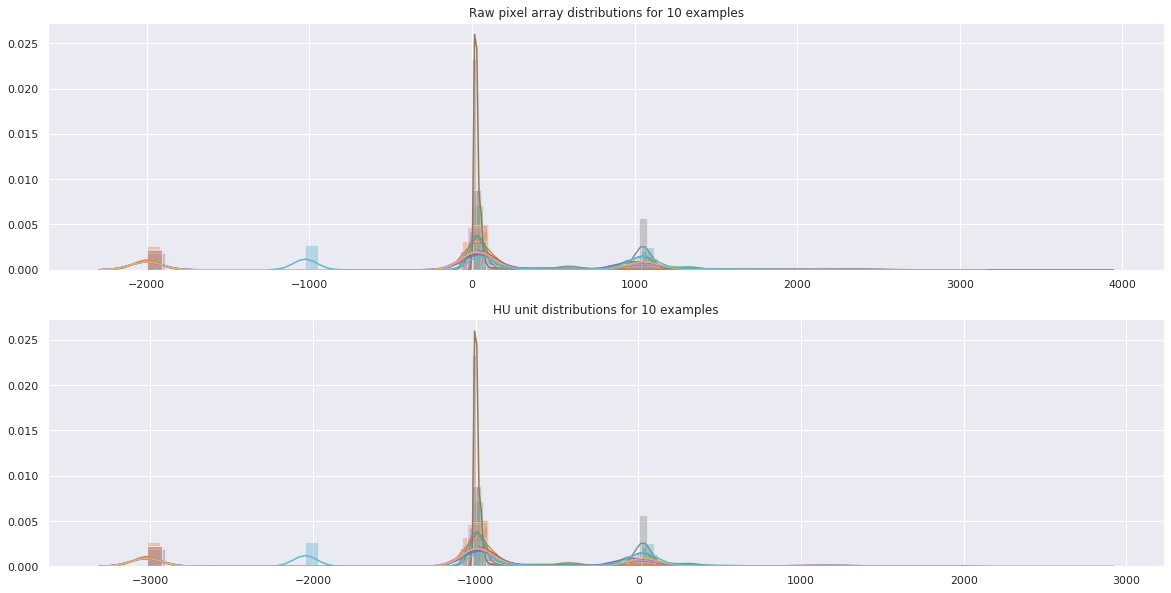

In [20]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
for file in train_files[0:10]:
    dataset = pydicom.dcmread(train_dir + file)
    image = dataset.pixel_array.flatten()
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    sns.distplot(image.flatten(), ax=ax[0]);
    sns.distplot(rescaled_image.flatten(), ax=ax[1])
ax[0].set_title("Raw pixel array distributions for 10 examples")
ax[1].set_title("HU unit distributions for 10 examples");

Let's take a look at the images themselves.

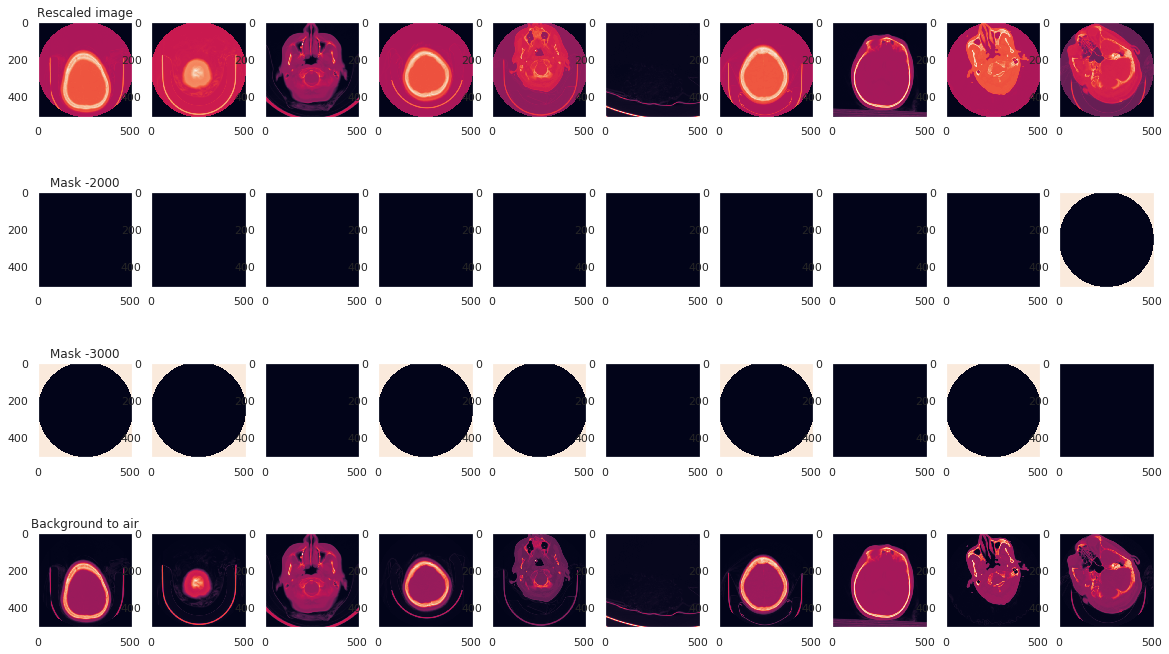

In [21]:
fig, ax = plt.subplots(4,10,figsize=(20,12))

for n in range(10):
    dataset = pydicom.dcmread(train_dir + train_files[n])
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    mask2000 = np.where((rescaled_image <= -1500) & (rescaled_image > -2500), 1, 0)
    mask3000 = np.where(rescaled_image <= -2500, 1, 0)
    ax[0,n].imshow(rescaled_image)
    rescaled_image[rescaled_image < -1024] = -1024
    ax[1,n].imshow(mask2000)
    ax[2,n].imshow(mask3000)
    ax[3,n].imshow(rescaled_image)
    ax[0,n].grid(False)
    ax[1,n].grid(False)
    ax[2,n].grid(False)
    ax[3,n].grid(False)
ax[0,0].set_title("Rescaled image")
ax[1,0].set_title("Mask -2000")
ax[2,0].set_title("Mask -3000");
ax[3,0].set_title("Background to air");

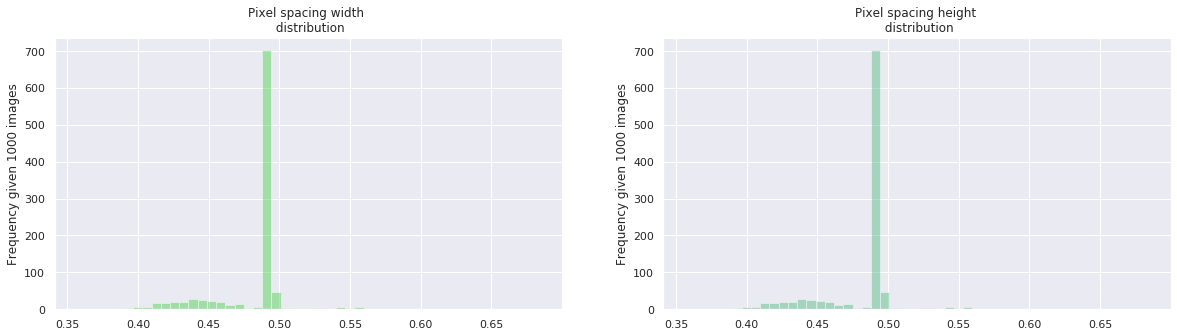

In [22]:
pixelspacing_w = []
pixelspacing_h = []
spacing_filenames = []
for file in train_files[0:1000]:
    dataset = pydicom.dcmread(train_dir + file)
    spacing = dataset.PixelSpacing
    pixelspacing_w.append(spacing[0])
    pixelspacing_h.append(spacing[1])
    spacing_filenames.append(file)
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(pixelspacing_w, ax=ax[0], color="Limegreen", kde=False)
ax[0].set_title("Pixel spacing width \n distribution")
ax[0].set_ylabel("Frequency given 1000 images")
sns.distplot(pixelspacing_h, ax=ax[1], color="Mediumseagreen", kde=False)
ax[1].set_title("Pixel spacing height \n distribution");
ax[1].set_ylabel("Frequency given 1000 images");

In [23]:
min_file = spacing_filenames[np.argmin(pixelspacing_w)]
max_file = spacing_filenames[np.argmax(pixelspacing_w)]

### ~ exploring DICOM files ~

We want to rescale the image, as they are DICOM files and compressed. The files come with the elements of the linear tranformation necessary to rescale the image.

In [24]:
def rescale_pixelarray(dataset):
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    rescaled_image[rescaled_image < -1024] = -1024
    return rescaled_image

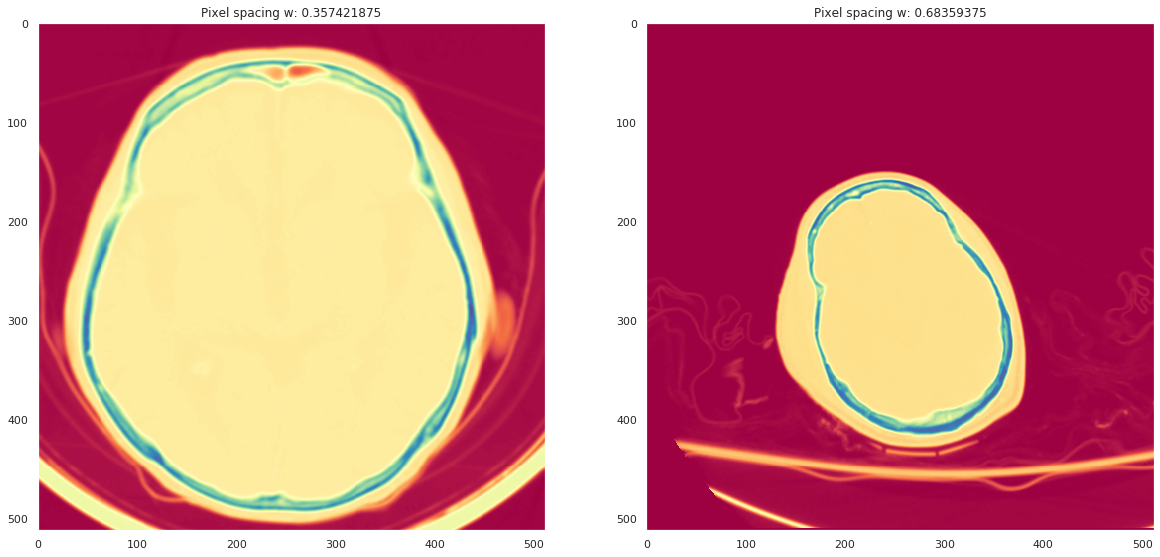

In [25]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

dataset_min = pydicom.dcmread(train_dir + min_file)
image_min = rescale_pixelarray(dataset_min)

dataset_max = pydicom.dcmread(train_dir + max_file)
image_max = rescale_pixelarray(dataset_max)

ax[0].imshow(image_min, cmap="Spectral")
ax[0].set_title("Pixel spacing w: " + str(np.min(pixelspacing_w)))
ax[1].imshow(image_max, cmap="Spectral");
ax[1].set_title("Pixel spacing w: " + str(np.max(pixelspacing_w)))
ax[0].grid(False)
ax[1].grid(False)

Work on spacing later

#### Windows are one of they key to a succesful model
A CT scan provides a 3-dimensional map based on variations of density of anatomical structures. This CT data can be presented in different ways to view structures within specific ranges of density.

In [26]:
def get_window_value(feature):
    if type(feature) == pydicom.multival.MultiValue:
        return np.int(feature[0])
    else:
        return np.int(feature)

In [27]:
window_widths = []
window_levels = []
spacing_filenames = []
for file in train_files[0:1000]:
    dataset = pydicom.dcmread(train_dir + file)
    win_width = get_window_value(dataset.WindowWidth)
    win_center = get_window_value(dataset.WindowCenter)
    window_widths.append(win_width)
    window_levels.append(win_center)
    spacing_filenames.append(file)

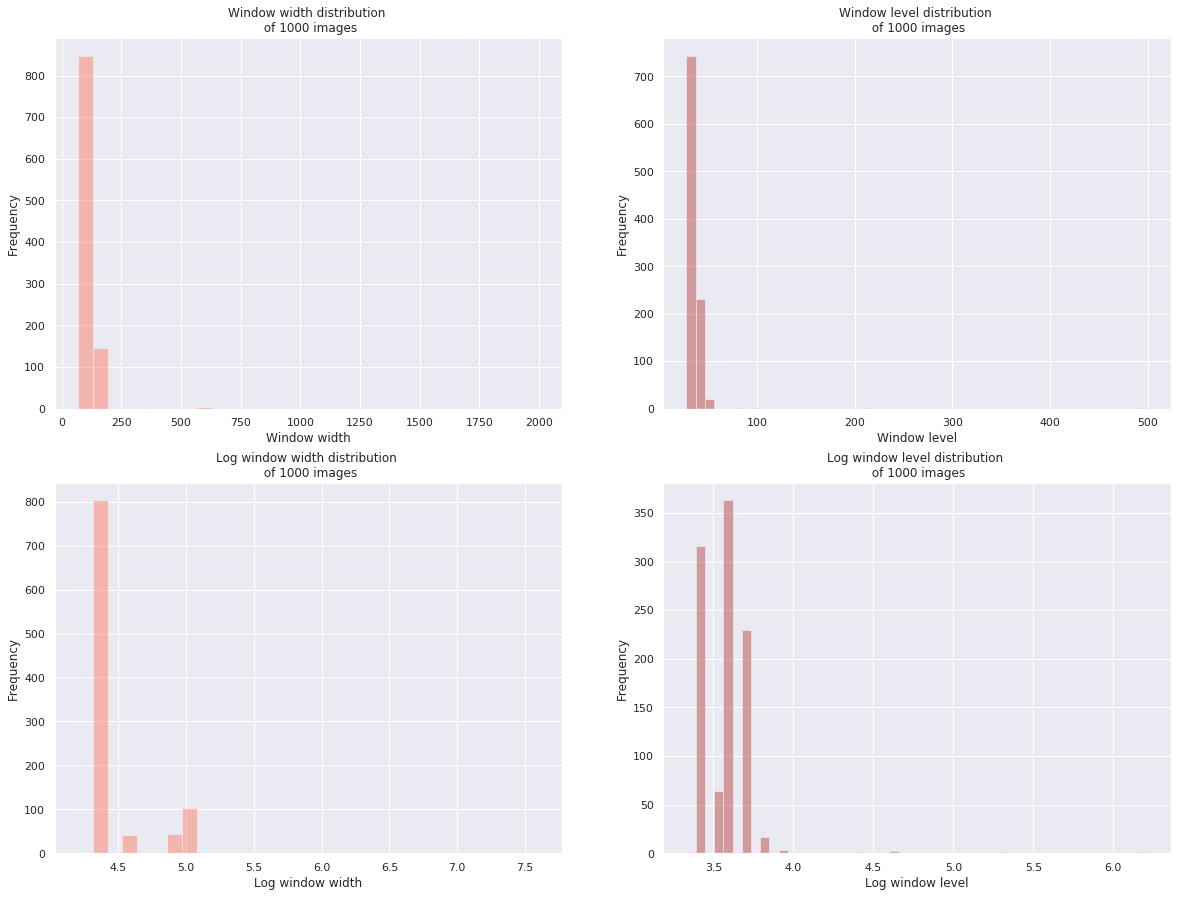

In [28]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

sns.distplot(window_widths, kde=False, ax=ax[0,0], color="Tomato")
ax[0,0].set_title("Window width distribution \n of 1000 images")
ax[0,0].set_xlabel("Window width")
ax[0,0].set_ylabel("Frequency")

sns.distplot(window_levels, kde=False, ax=ax[0,1], color="Firebrick")
ax[0,1].set_title("Window level distribution \n of 1000 images")
ax[0,1].set_xlabel("Window level")
ax[0,1].set_ylabel("Frequency")

sns.distplot(np.log(window_widths), kde=False, ax=ax[1,0], color="Tomato")
ax[1,0].set_title("Log window width distribution \n of 1000 images")
ax[1,0].set_xlabel("Log window width")
ax[1,0].set_ylabel("Frequency")

sns.distplot(np.log(window_levels), kde=False, ax=ax[1,1], color="Firebrick")
ax[1,1].set_title("Log window level distribution \n of 1000 images")
ax[1,1].set_xlabel("Log window level")
ax[1,1].set_ylabel("Frequency");

In [29]:
doc_windows = pd.DataFrame(index=spacing_filenames, columns=["win_width", "win_level"])
doc_windows["win_width"] = window_widths
doc_windows["win_level"] = window_levels

In [30]:
doc_windows.head()



,win_width,win_level
ID_10cd92e6a.dcm,80,30
ID_03b9718d6.dcm,80,30
ID_209220ddf.dcm,80,36
ID_20fa13e70.dcm,80,30
ID_0af4813a4.dcm,80,30


Now that we have seen the window values, we can create function to manually change our windows.

### EDIT THIS CODE

In [31]:
def set_manual_window(hu_image, custom_center, custom_width):
    min_value = custom_center - (custom_width/2)
    max_value = custom_center + (custom_width/2)
    hu_image[hu_image < min_value] = min_value
    hu_image[hu_image > max_value] = max_value
    return hu_image

Let's look at three images. For each image, the first result will show a raw non-rescaled image. The following one is rescled. The third is windowed according to the doctor and the forth according to our function.

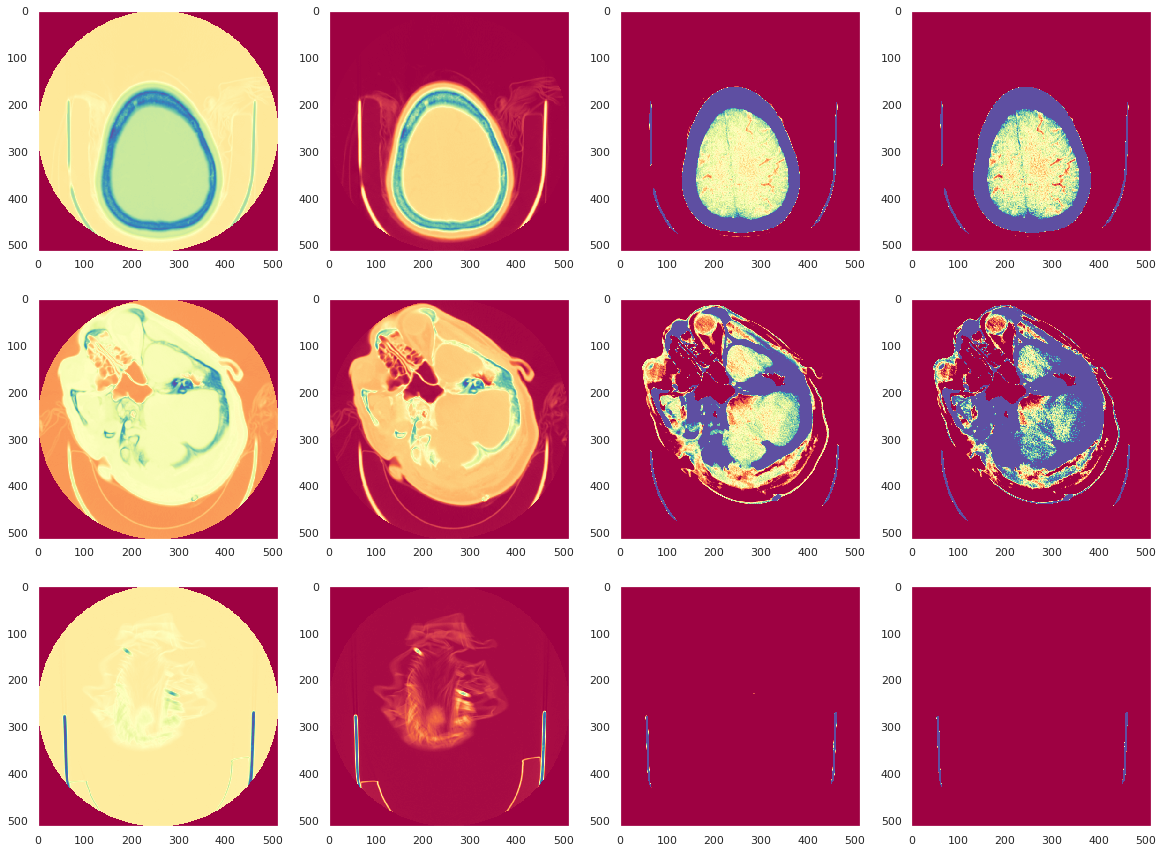

In [32]:
fig, ax = plt.subplots(3,4,figsize=(20,15))

docs_dict = {"ID_10cd92e6a.dcm": {"width": 80, "level": 30},
             "ID_25c66e09c.dcm": {"width": 100, "level": 40},
             "ID_1cf84615b.dcm": {"width": 150, "level": 40}}
n = 0
for file in ["ID_10cd92e6a.dcm", "ID_25c66e09c.dcm", "ID_1cf84615b.dcm"]:
    dataset = pydicom.dcmread(train_dir + file)
    pixelarray = dataset.pixel_array
    
    ax[n,0].imshow(pixelarray, cmap="Spectral")
    ax[n,0].grid(False)
    
    rescaled_image = rescale_pixelarray(dataset)
    ax[n,1].imshow(rescaled_image, cmap="Spectral")
    ax[n,1].grid(False)
    
    org_windowed_image = set_manual_window(rescaled_image, docs_dict[file]["level"], docs_dict[file]["width"])
    ax[n,2].imshow(org_windowed_image, cmap="Spectral")
    ax[n,2].grid(False)
    
    new_windowed_image = set_manual_window(rescaled_image, 30, 50)
    ax[n,3].imshow(new_windowed_image, cmap="Spectral")
    ax[n,3].grid(False)
    
    n+=1

### ~ Create Model ~

In [33]:
train_brute_force = True
train_anysubtype_network = False

In [34]:
MODELOUTPUT_PATH_BRUTE_FORCE = "bruteforce_best_model.hdf5"
MODELOUTPUT_PATH_ANYSUBTYPE = "anysubtype_best_model.hdf5"
brute_force_model_input = "/storage/data_bruteforce_best_model.hdf5"
brute_force_losses_path = "/storage/data/brute_force_losses.csv"
any_subtype_model_input = "/storage/data/anysubtype_best_model.hdf5"

In [35]:


class Preprocessor:    
    
    def __init__(self, path, backbone, hu_min_value, hu_max_value, augment=False):
        self.path = path
        self.backbone = backbone
        self.nn_input_shape = backbone["nn_input_shape"]
        self.hu_min_value = hu_min_value
        self.hu_max_value = hu_max_value
        self.augment = augment
        
    # 1. We need to load the dicom dataset
    def load_dicom_dataset(self, filename):
        dataset = pydicom.dcmread(self.path + filename)
        return dataset
    
    # 2. We need to rescale the pixelarray to Hounsfield units
    #    and we need to focus on our custom window:
    def get_hounsfield_window(self, dataset, min_value, max_value):
        try:
            hu_image = rescale_pixelarray(dataset)
            windowed_image = set_manual_window(hu_image, min_value, max_value)
        except ValueError:
            # set to level 
            windowed_image = min_value * np.ones((self.nn_input_shape[0], self.nn_input_shape[1]))
        return windowed_image
        
    
    # 3. Resize the image to the input shape of our CNN
    def resize(self, image):
        image = resize(image, self.nn_input_shape)
        return image
    
    # 4. If we like to augment our image, let's do it:
    def augment_img(self, image): 
        augment_img = iaa.Sequential([
            #iaa.Crop(keep_size=True, percent=(0.01, 0.05), sample_independently=False),
            #iaa.Affine(rotate=(-10, 10)),
            iaa.Fliplr(0.5)])
        image_aug = augment_img.augment_image(image)
        return image_aug
    
    def fill_channels(self, image):
        filled_image = np.stack((image,)*3, axis=-1)
        return filled_image
    
    def preprocess(self, identifier):
        filename = identifier +  ".dcm"
        dataset = self.load_dicom_dataset(filename)
        windowed_image = self.get_hounsfield_window(dataset, self.hu_min_value, self.hu_max_value)
        image = self.resize(windowed_image)
        if self.augment:
            image = self.augment_img(image)
        image = self.fill_channels(image)
        return image
    
    def normalize(self, image):
        return (image - self.hu_min_value)/(self.hu_max_value-self.hu_min_value) * 0.5

In [36]:
class DataLoader(Sequence):
    
    def __init__(self, dataframe,
                 preprocessor,
                 batch_size,
                 shuffle,
                 num_classes=6,
                 steps=None):
        
        self.preprocessor = preprocessor
        self.data_ids = dataframe.index.values
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = self.preprocessor.backbone["nn_input_shape"]
        self.preprocess_fun = self.preprocessor.backbone["preprocess_fun"]
        self.num_classes = num_classes
        self.current_epoch=0
        
        self.steps=steps
        if self.steps is not None:
            self.steps = np.round(self.steps/3) * 3
            self.undersample()
        
    def undersample(self):
        part = np.int(self.steps/3 * self.batch_size)
        zero_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 0].index.values, size=2*part, replace=False)
        hot_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 1].index.values, size=1*part, replace=False)
        self.data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(self.data_ids)
        
    # defines the number of steps per epoch
    def __len__(self):
        if self.steps is None:
            return np.int(np.ceil(len(self.data_ids) / np.float(self.batch_size)))
        else:
            return 3*np.int(self.steps/3) 
    
    # at the end of an epoch: 
    def on_epoch_end(self):
        # if steps is None and shuffle is true:
        if self.steps is None:
            self.data_ids = self.dataframe.index.values
            if self.shuffle:
                np.random.shuffle(self.data_ids)
        else:
            self.undersample()
        self.current_epoch += 1
    
    # should return a batch of images
    def __getitem__(self, item):
        # select the ids of the current batch
        current_ids = self.data_ids[item*self.batch_size:(item+1)*self.batch_size]
        X, y = self.__generate_batch(current_ids)
        return X, y
    
    # collect the preprocessed images and targets of one batch
    def __generate_batch(self, current_ids):
        X = np.empty((self.batch_size, *self.input_shape, 3))
        y = np.empty((self.batch_size, self.num_classes))
        for idx, ident in enumerate(current_ids):
            # Store sample
            image = self.preprocessor.preprocess(ident)
            X[idx] = self.preprocessor.normalize(image)
            # Store class
            y[idx] = self.__get_target(ident)
        return X, y
    
    # extract the targets of one image id:
    def __get_target(self, ident):
        targets = self.dataframe.loc[ident].values
        return targets

In [37]:
pretrained_models_path = INPUT_PATH + 'keras-pretrained_models/'
os.listdir(pretrained_models_path)

['resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
 '.ipynb_checkpoints',
 'imagenet_class_index.json',
 'xception_weights_tf_dim_ordering_tf_kernels.h5',
 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5',
 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'Kuszma.JPG',
 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5']

In [38]:
pretrained_models = {
    "resnet_50": {"weights": "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5",
                  "nn_input_shape": (224,224),
                  "preprocess_fun": preprocess_resnet_50},
    "vgg16": {"weights": "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",
              "nn_input_shape": (224,224),
              "preprocess_fun": preprocess_vgg_16},
}

In [39]:
def resnet_50():
    weights_path = pretrained_models_path + pretrained_models["resnet_50"]["weights"]
    net = ResNet50(include_top=False, weights=weights_path)
    for layer in net.layers:
        layer.trainable = False
    return net

def vgg_16():
    weights_path = pretrained_models_path + pretrained_models["vgg_16"]["weights"]
    net = VGG16(include_top=False, weights=weights_path)
    for layer in net.layers:
        layer.trainable = False
    return net

In [40]:
class MyNetwork:
    
    def __init__(self,
                 model_fun,
                 loss_fun,
                 metrics_list,
                 train_generator,
                 dev_generator,
                 epochs,
                 num_classes=6,
                 checkpoint_path=MODELOUTPUT_PATH_BRUTE_FORCE):
        self.model_fun = model_fun
        self.loss_fun = loss_fun
        self.metrics_list = metrics_list
        self.train_generator = train_generator
        self.dev_generator = dev_generator
        self.epochs = epochs
        self.num_classes = num_classes
        self.checkpoint_path = checkpoint_path 
        self.checkpoint = ModelCheckpoint(filepath=self.checkpoint_path,
                                          mode="min",
                                          verbose=1,
                                          save_best_only=True,
                                          save_weights_only=True,
                                          period=1)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                           factor=0.5,
                                           patience=2,
                                           min_lr=1e-8,
                                           mode="min")
        self.e_stopping = EarlyStopping(monitor="val_loss",
                                        min_delta=0.01,
                                        patience=5,
                                        mode="min",
                                        restore_best_weights=True)
        
    def build_model(self):
        base_model = self.model_fun()
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.3)(x)
        x = Dense(100, activation="relu")(x)
        x = Dropout(0.3)(x)
        pred = Dense(self.num_classes,
                     kernel_initializer=he_normal(seed=11),
                     kernel_regularizer=l2(0.05),
                     bias_regularizer=l2(0.05), activation="sigmoid")(x)
        self.model = Model(inputs=base_model.input, outputs=pred)
    
    def compile_model(self):
        self.model.compile(optimizer=Adam(learning_rate=LR),
                           loss=self.loss_fun, 
                           metrics=self.metrics_list)
    
    def learn(self):
        return self.model.fit_generator(generator=self.train_generator,
                    validation_data=self.dev_generator,
                    epochs=self.epochs,
                    callbacks=[self.checkpoint, self.reduce_lr, self.e_stopping],
                    #use_multiprocessing=False,
                    workers=8)
    
    def load_weights(self, path):
        self.model.load_weights(path)
    
    def predict(self, test_generator):
        predictions = self.model.predict_generator(test_generator, workers=8)
        return predictions

In [41]:
split_seed = 1
kfold = StratifiedKFold(n_splits=5, random_state=split_seed).split(np.arange(traindf.shape[0]), traindf["any"].values)

train_idx, dev_idx = next(kfold)

train_data = traindf.iloc[train_idx]
dev_data = traindf.iloc[dev_idx]

#train_data, dev_data = train_test_split(traindf, test_size=0.1, stratify=traindf.values, random_state=split_seed)
print(train_data.shape)
print(dev_data.shape)

(83017, 6)
(20755, 6)


In [42]:
dev_data.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0
ID_0000aee4b,0,0,0,0,0,0


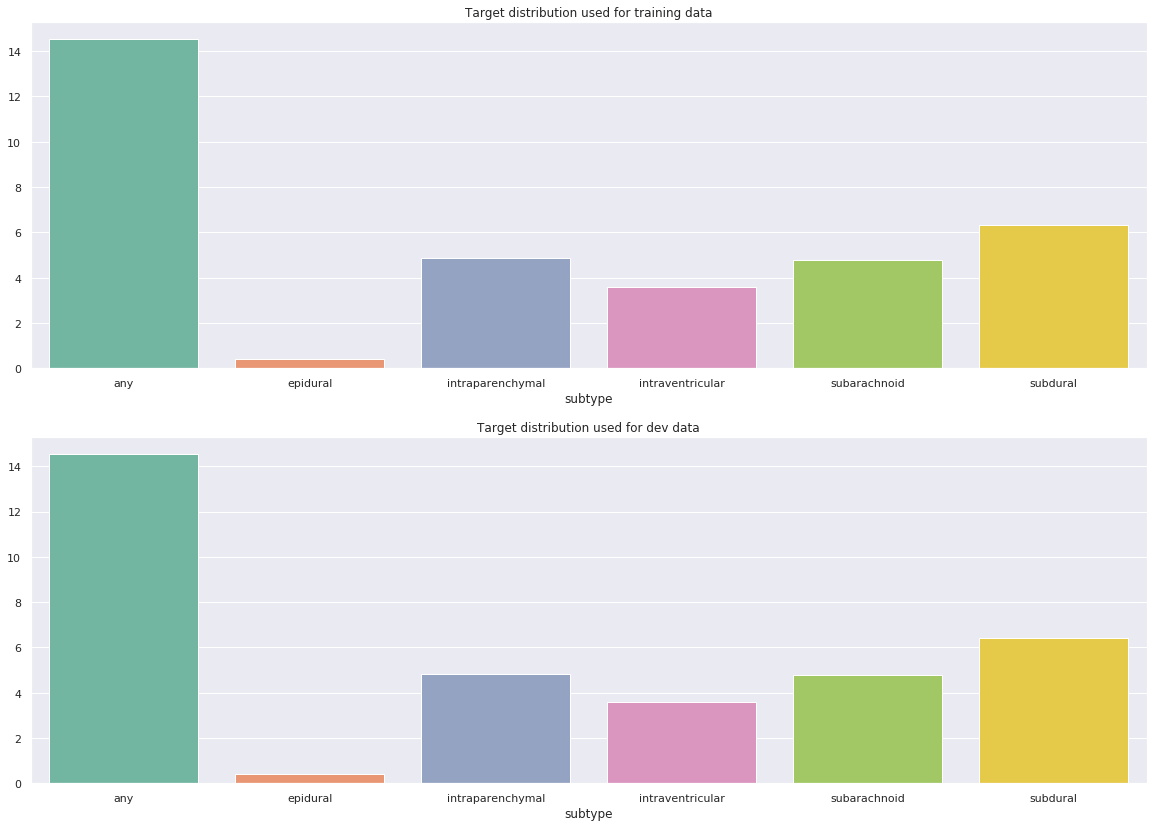

In [43]:
pos_perc_train = train_data.sum() / train_data.shape[0] * 100
pos_perc_dev = dev_data.sum() / dev_data.shape[0] * 100

fig, ax = plt.subplots(2,1,figsize=(20,14))
sns.barplot(x=pos_perc_train.index, y=pos_perc_train.values, palette="Set2", ax=ax[0]);
ax[0].set_title("Target distribution used for training data")
sns.barplot(x=pos_perc_dev.index, y=pos_perc_dev.values, palette="Set2", ax=ax[1]);
ax[1].set_title("Target distribution used for dev data");

In [44]:
def np_multilabel_loss(y_true, y_pred, class_weights=None):
    y_pred = np.where(y_pred > 1-(1e-07), 1-1e-07, y_pred)
    y_pred = np.where(y_pred < 1e-07, 1e-07, y_pred)
    single_class_cross_entropies = - np.mean(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred), axis=0)
    
    print(single_class_cross_entropies)
    if class_weights is None:
        loss = np.mean(single_class_cross_entropies)
    else:
        loss = np.sum(class_weights*single_class_cross_entropies)
    return loss

def get_raw_xentropies(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
    xentropies = y_true * tf.log(y_pred) + (1-y_true) * tf.log(1-y_pred)
    return -xentropies

# multilabel focal loss equals multilabel loss in case of alpha=0.5 and gamma=0 
def multilabel_focal_loss(class_weights=None, alpha=0.5, gamma=2):
    def mutlilabel_focal_loss_inner(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        xentropies = get_raw_xentropies(y_true, y_pred)

        # compute pred_t:
        y_t = tf.where(tf.equal(y_true,1), y_pred, 1.-y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha * tf.ones_like(y_true), (1-alpha) * tf.ones_like(y_true))

        # compute focal loss contributions
        focal_loss_contributions =  tf.multiply(tf.multiply(tf.pow(1-y_t, gamma), xentropies), alpha_t) 

        # our focal loss contributions have shape (n_samples, s_classes), we need to reduce with mean over samples:
        focal_loss_per_class = tf.reduce_mean(focal_loss_contributions, axis=0)

        # compute the overall loss if class weights are None (equally weighted):
        if class_weights is None:
            focal_loss_result = tf.reduce_mean(focal_loss_per_class)
        else:
            # weight the single class losses and compute the overall loss
            weights = tf.constant(class_weights, dtype=tf.float32)
            focal_loss_result = tf.reduce_sum(tf.multiply(weights, focal_loss_per_class))
            
        return focal_loss_result
    return mutlilabel_focal_loss_inner

In [45]:
BACKBONE = "resnet_50"
BATCH_SIZE = 16
TEST_BATCH_SIZE = 5
MIN_VALUE = 0
MAX_VALUE = 90
STEPS = 50
EPOCHS = 10

LR = 0.0001

In [46]:
train_preprocessor = Preprocessor(path=train_dir,
                                  backbone=pretrained_models[BACKBONE],
                                  hu_min_value=MIN_VALUE,
                                  hu_max_value=MAX_VALUE,
                                  augment=True)

dev_preprocessor = Preprocessor(path=train_dir,
                                backbone=pretrained_models[BACKBONE],
                                hu_min_value=MIN_VALUE,
                                hu_max_value=MAX_VALUE,
                                augment=False)

test_preprocessor = Preprocessor(path=test_dir,
                                backbone=pretrained_models[BACKBONE],
                                hu_min_value=MIN_VALUE,
                                hu_max_value=MAX_VALUE,
                                augment=False)

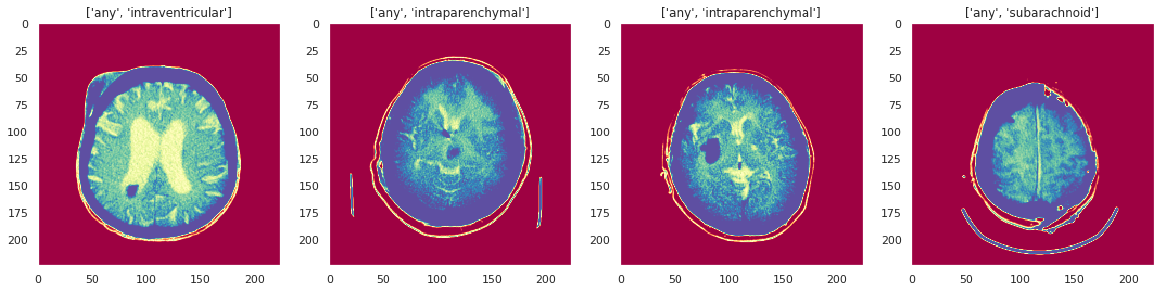

In [47]:
fig, ax = plt.subplots(1,4,figsize=(20,20))


for m in range(4):
    example = train_data.index.values[m]
    title = [col for col in train_data.loc[example,:].index if train_data.loc[example, col]==1]
    if len(title) == 0:
        title="Healthy"
    preprocess_example = train_preprocessor.preprocess(example)
    ax[m].imshow(preprocess_example[:,:,2], cmap="Spectral")
    ax[m].grid(False)
    ax[m].set_title(title);

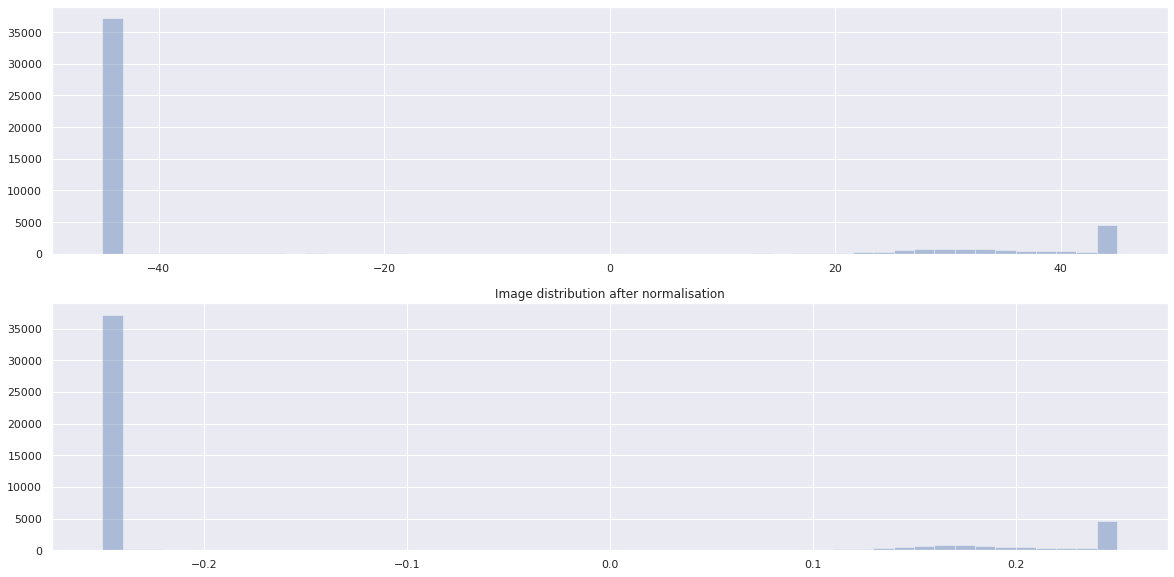

In [48]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
sns.distplot(preprocess_example[:,:,2].flatten(), kde=False, ax=ax[0])
sns.distplot(train_preprocessor.normalize(preprocess_example)[:,:,2].flatten(), kde=False)
plt.title("Image distribution after normalisation");

In [49]:
train_preprocessor.normalize(preprocess_example[:,:,2]).min()

-0.25

In [50]:
train_preprocessor.normalize(preprocess_example[:,:,2]).max()


0.25

In [51]:
train_dataloader = DataLoader(train_data,
                              train_preprocessor,
                              BATCH_SIZE,
                              shuffle=True,
                              steps=STEPS)

dev_dataloader = DataLoader(dev_data, 
                            dev_preprocessor,
                            BATCH_SIZE,
                            shuffle=True,
                            steps=STEPS)

test_dataloader = DataLoader(testdf, 
                             test_preprocessor,
                             TEST_BATCH_SIZE,
                             shuffle=False)

In [52]:
train_dataloader.__len__()


51

In [53]:
dev_data.loc[dev_dataloader.data_ids]["any"].value_counts()

0    544
1    272
Name: any, dtype: int64

In [54]:
len(train_dataloader.data_ids)/BATCH_SIZE

51.0

In [55]:
train_data.loc[train_dataloader.data_ids]["any"].value_counts()

0    544
1    272
Name: any, dtype: int64

In [56]:
test_dataloader.__len__()

15709

In [57]:
816*6

4896

In [58]:
dev_dataloader.__len__()

51

In [59]:
my_class_weights = [0.5, 0.1, 0.1, 0.1, 0.1, 0.1]

In [60]:
def turn_pred_to_dataframe(data_df, pred):
    df = pd.DataFrame(pred, columns=data_df.columns, index=data_df.index)
    df = df.stack().reset_index()
    df.loc[:, "ID"] = df.id.str.cat(df.subtype, sep="_")
    df = df.drop(["id", "subtype"], axis=1)
    df = df.rename({0: "Label"}, axis=1)
    return df

In [61]:
train_brute_force = False
if train_brute_force:
    
    model = MyNetwork(model_fun= VGG16,
                      loss_fun="binary_crossentropy", 
                      metrics_list = [multilabel_focal_loss(class_weights=my_class_weights, alpha=0.5, gamma=0)],
                      #metrics_list=[multilabel_focal_loss(alpha=0.5, gamma=0)],
                      train_generator=train_dataloader,
                      dev_generator=dev_dataloader,
                      epochs=EPOCHS,
                      num_classes=6)
    model.build_model()
    model.compile_model()
    history = model.learn()
    
    print(history.history.keys())
    
    fig, ax = plt.subplots(2,1,figsize=(20,5))
    ax[0].plot(history.history["loss"], 'o-')
    ax[0].plot(history.history["val_loss"], 'o-')
    ax[1].plot(history.history["lr"], 'o-')
    
    #test_pred = model.predict(test_dataloader)[0:testdf.shape[0]]
    #dev_pred = model.predict(dev_dataloader)
    
    #test_pred_df = turn_pred_to_dataframe(testdf, test_pred)
    #dev_pred_df = turn_pred_to_dataframe(dev_data, dev_pred)
    
    #test_pred_df.to_csv("brute_force_test_pred.csv", index=False)
    #dev_pred_df.to_csv("brute_force_dev_pred.csv", index=False)
    predictions_raw = model.predict(dev_dataloader)
    predictions_df = pd.DataFrame(predictions_raw, columns=train_data.loc[train_dataloader.data_ids].columns, index=train_data.loc[train_dataloader.data_ids].index)

In [62]:
#predictions_df.shape

NameError: name 'predictions_df' is not defined

In [ ]:
#predictions_df.head()

In [ ]:
#results = dev_data.loc[dev_dataloader.data_ids]

In [ ]:
#results.head()

In [ ]:
#combined = predictions_df.merge(results, left_index = True, right_index = True)

In [ ]:
#combined.head()

In [ ]:
#dev_proba = model.predict(dev_dataloader)
#dev_proba.shape

In [ ]:
real_percentages = []
for column in dev_data.loc[dev_dataloader.data_ids].columns:
    print(f'{column} :\n{dev_data.loc[dev_dataloader.data_ids][column].value_counts()[1]/800}\n')
    real_percentages.append(dev_data.loc[dev_dataloader.data_ids][column].value_counts()[1]/800)

In [ ]:
# plt.figure(figsize=(20,5))
# colors = ['orange', 'green', 'blue', 'purple', 'red', 'yellow']
# for n in range(6):
#     sns.distplot(dev_proba[:,n], color = colors[n])
    

In [63]:
alpha_subtypes = 0.25 
gamma_subtypes = 2

In [64]:
class AnySubtypeNetwork(MyNetwork):
    
    def __init__(self,
                 model_fun,
                 loss_fun,
                 metrics_list,
                 train_generator,
                 dev_generator,
                 epochs,
                 num_subtype_classes=5,
                 checkpoint_path=MODELOUTPUT_PATH_ANYSUBTYPE):
        MyNetwork.__init__(self, 
                           model_fun=model_fun,
                           loss_fun=loss_fun,
                           metrics_list=metrics_list,
                           train_generator=train_generator,
                           dev_generator=dev_generator,
                           epochs=epochs,
                           num_classes=num_subtype_classes)
    
    def build_model(self):
        base_model = self.model_fun()
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.5)(x)
        any_logits = Dense(1, kernel_initializer=he_normal(seed=11))(x)
        any_pred = Activation("sigmoid", name="any_predictions")(any_logits)
        x = concatenate([any_pred, x])
        sub_pred = Dense(self.num_classes,
                         name="subtype_pred",
                         kernel_initializer=he_normal(seed=12),
                         activation="sigmoid")(x) 
        self.model = Model(inputs=base_model.input, outputs=[any_pred, sub_pred])
    
    def compile_model(self):
        self.model.compile(optimizer=Adam(LR),
                           loss=['binary_crossentropy', multilabel_focal_loss(alpha=alpha_subtypes, gamma=gamma_subtypes)],
                           loss_weights = [1., 0.],
                           metrics=self.metrics_list)

In [66]:
class AnySubtypeDataLoader(Sequence):
    
    def __init__(self, dataframe,
                 preprocessor,
                 batch_size,
                 num_classes=5,
                 shuffle=False,
                 steps=None):
        self.preprocessor = preprocessor
        self.data_ids = dataframe.index.values
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = self.preprocessor.backbone["nn_input_shape"]
        self.preprocess_fun = self.preprocessor.backbone["preprocess_fun"]
        self.num_classes = num_classes
        self.current_epoch=0
        
        self.steps=steps
        if self.steps is not None:
            self.steps = np.round(self.steps/2) * 2
            self.undersample()
        
    def undersample(self):
        part = np.int(self.steps/2 * self.batch_size)
        zero_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 0].index.values, size=1*part, replace=False)
        hot_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 1].index.values, size=1*part, replace=False)
        self.data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(self.data_ids)
    
    # defines the number of steps per epoch
    def __len__(self):
        if self.steps is None:
            return np.int(np.ceil(len(self.data_ids) / np.float(self.batch_size)))
        else:
            return 2*np.int(self.steps/2) 
    
    # at the end of an epoch: 
    def on_epoch_end(self):
        # if steps is None and shuffle is true:
        if self.steps is None:
            self.data_ids = self.dataframe.index.values
            if self.shuffle:
                np.random.shuffle(self.data_ids)
        else:
            self.undersample()
        self.current_epoch += 1
    
    # should return a batch of images
    def __getitem__(self, item):
        # select the ids of the current batch
        current_ids = self.data_ids[item*self.batch_size:(item+1)*self.batch_size]
        X, y_any, y_subtype = self.__generate_batch(current_ids)
        return X, [y_any, y_subtype]
    
    # collect the preprocessed images and targets of one batch
    def __generate_batch(self, current_ids):
        X = np.empty((self.batch_size, *self.input_shape, 3))
        y_subtype = np.empty((self.batch_size, self.num_classes))
        y_any = np.empty((self.batch_size, 1))
        for idx, ident in enumerate(current_ids):
            # Store sample
            image = self.preprocessor.preprocess(ident)
            X[idx] = self.preprocessor.normalize(image)
            # Store class
            y_any[idx], y_subtype[idx] = self.__get_target(ident)
        return X, y_any, y_subtype
    
    # extract the targets of one image id:
    def __get_target(self, ident):
        y_any = self.dataframe.loc[ident, "any"]
        y_subtype = self.dataframe.drop("any", axis=1).loc[ident].values
        return y_any, y_subtype

In [67]:
train_dataloader = AnySubtypeDataLoader(train_data,
                                        train_preprocessor,
                                        BATCH_SIZE,
                                        steps=STEPS)
dev_dataloader = AnySubtypeDataLoader(dev_data, 
                                      dev_preprocessor,
                                      BATCH_SIZE,
                                      steps=STEPS,
                                      shuffle=False)

test_dataloader = AnySubtypeDataLoader(testdf, 
                                       test_preprocessor,
                                       TEST_BATCH_SIZE,
                                       shuffle=False)

In [68]:
X, [y1, y2] = train_dataloader.__getitem__(0)

In [69]:
y1.shape

(16, 1)

In [70]:
y2.shape

(16, 5)

In [71]:
X.shape

(16, 224, 224, 3)

In [72]:
y1[0]

array([0.])

In [73]:
y2[0]

array([0., 0., 0., 0., 0.])

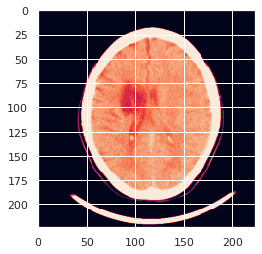

In [74]:
plt.imshow(X[0,:,:,0])

In [75]:
train_dataloader.__len__()

50

In [76]:
len(train_dataloader.data_ids)

800

In [77]:
train_data.loc[train_dataloader.data_ids].sum() / train_data.loc[train_dataloader.data_ids].shape[0]

subtype
any                 0.50000
epidural            0.01250
intraparenchymal    0.17250
intraventricular    0.12625
subarachnoid        0.17500
subdural            0.20625
dtype: float64

W1111 22:31:14.269849 140511338899264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
W1111 22:31:21.987940 140511338899264 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1111 22:31:23.022815 140511338899264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf

Epoch 1/50
50/50 [==============================] - 23s 463ms/step - loss: 0.8201 - any_predictions_loss: 0.8201 - subtype_pred_loss: 0.2808 - any_predictions_binary_crossentropy: 0.8201 - subtype_pred_mutlilabel_focal_loss_inner: 0.4325 - val_loss: 1.0715 - val_any_predictions_loss: 0.9112 - val_subtype_pred_loss: 0.1113 - val_any_predictions_binary_crossentropy: 0.9112 - val_subtype_pred_mutlilabel_focal_loss_inner: 0.3290

Epoch 00001: val_loss improved from inf to 1.07153, saving model to bruteforce_best_model.hdf5
Epoch 2/50
50/50 [==============================] - 17s 344ms/step - loss: 0.7895 - any_predictions_loss: 0.7895 - subtype_pred_loss: 0.2722 - any_predictions_binary_crossentropy: 0.7895 - subtype_pred_mutlilabel_focal_loss_inner: 0.4244 - val_loss: 0.9418 - val_any_predictions_loss: 0.9504 - val_subtype_pred_loss: 0.1118 - val_any_predictions_binary_crossentropy: 0.9504 - val_subtype_pred_mutlilabel_focal_loss_inner: 0.3300

Epoch 00002: val_loss improved from 1.07153 t

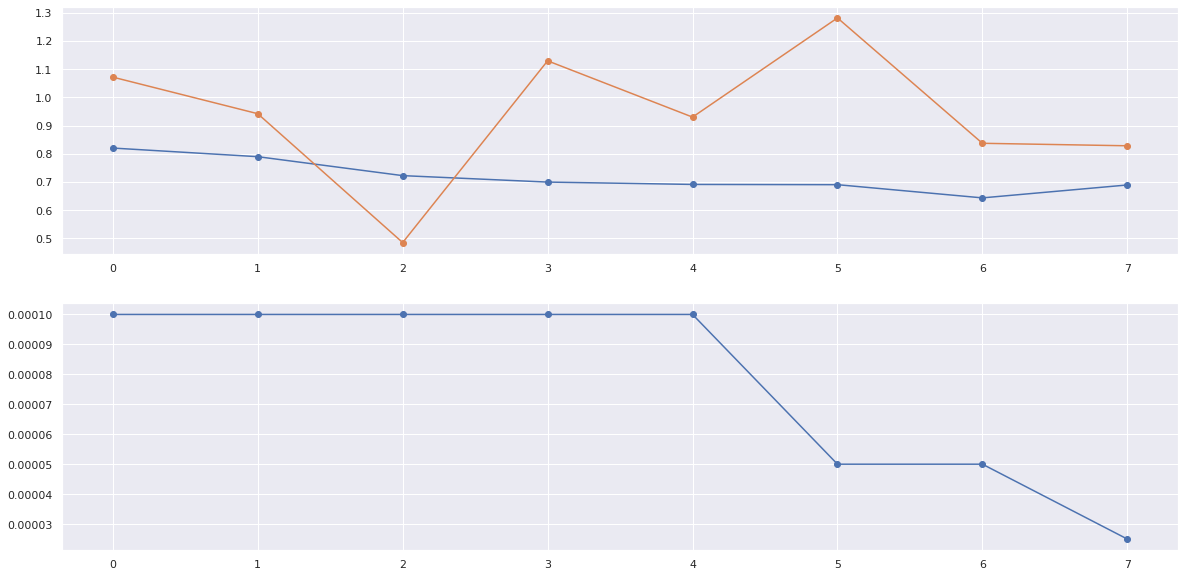

In [78]:
train_anysubtype_network = True
if train_anysubtype_network:
    model = AnySubtypeNetwork(model_fun=resnet_50,
                              loss_fun=None,
                              metrics_list={"any_predictions":"binary_crossentropy",
                                            "subtype_pred": multilabel_focal_loss(alpha=0.5, gamma=0)},
                              train_generator=train_dataloader,
                              dev_generator=dev_dataloader,
                              epochs=50) 
    model.build_model()
    model.compile_model()
    history = model.learn()
    
    print(history.history.keys())
    
    fig, ax = plt.subplots(2,1,figsize=(20,10))
    ax[0].plot(history.history["loss"], 'o-')
    ax[0].plot(history.history["val_loss"], 'o-')
    ax[1].plot(history.history["lr"], 'o-')
else:
    model = AnySubtypeNetwork(model_fun=resnet_50,
                              loss_fun=None,
                              metrics_list={"any_predictions":"binary_crossentropy",
                                            "subtype_pred": multilabel_focal_loss(alpha=0.5, gamma=0)},
                              train_generator=train_dataloader,
                              dev_generator=dev_dataloader,
                              epochs=50) 
    model.build_model()
    #model.load_weights(any_subtype_model_input)